# Inventory Dynamics

------

#### John Stachurski
#### Prepared for the CBC Computational Workshop May 2024

-----

## Overview

This lecture explores the inventory dynamics of a firm using so-called s-S inventory control.

Loosely speaking, this means that the firm

- waits until inventory falls below some value $ s $  
- and then restocks with a bulk order of $ S $ units (or, in some models, restocks up to level $ S $).  


We will be interested in the distribution of the associated Markov process,
which can be thought of as cross-sectional distributions of inventory levels
across a large number of firms, all of which

1. evolve independently and  
1. have the same dynamics.

This lecture will help use become familiar with NumPy.

(Later we will try similar operations with JAX)

We will use the following imports:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple

## Sample paths

Consider a firm with inventory $ X_t $.

The firm waits until $ X_t \leq s $ and then restocks up to $ S $ units.

It faces stochastic demand $ \{ D_t \} $, which we assume is IID across time and
firms.

With notation $ a^+ := \max\{a, 0\} $, inventory dynamics can be written
as

$$
X_{t+1} =
    \begin{cases}
      ( S - D_{t+1})^+ & \quad \text{if } X_t \leq s \\
      ( X_t - D_{t+1} )^+ &  \quad \text{if } X_t > s
    \end{cases}
$$

In what follows, we will assume that each $ D_t $ is lognormal, so that

$$
    D_t = \exp(\mu + \sigma Z_t)
$$

where $ \mu $ and $ \sigma $ are parameters and $ \{Z_t\} $ is IID
and standard normal.

Here’s a `namedtuple` that stores parameters.

In [2]:
Parameters = namedtuple('Parameters', ['s', 'S', 'μ', 'σ'])

# Create a default instance
params = Parameters(s=10, S=100, μ=1.0, σ=0.5)

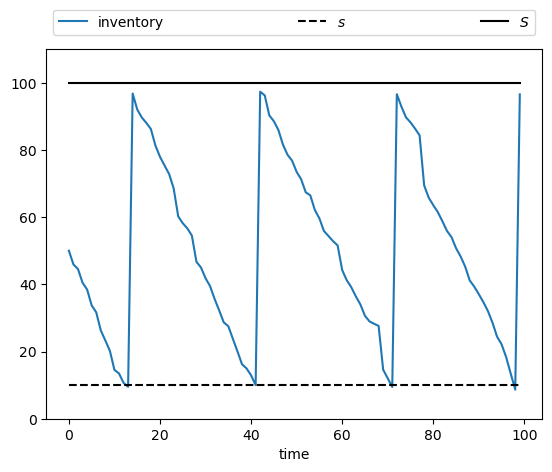

In [3]:

def update(params, x):
    "Update the state from t to t+1 given current state x."
    Z = np.random.randn()
    D = np.exp(params.μ + params.σ * Z)
    if x <= params.s:
        return max(params.S - D, 0)
    else:
        return max(x - D, 0)

def sim_inventory_path(x_init, sim_length):

    X = np.empty(sim_length)
    X[0] = x_init

    for t in range(sim_length-1):
        X[t+1] = update(params, X[t])
    return X

s, S = params.s, params.S
sim_length = 100
x_init = 50

X = sim_inventory_path(x_init, sim_length)

fig, ax = plt.subplots()
bbox = (0., 1.02, 1., .102)
legend_args = {'ncol': 3,
               'bbox_to_anchor': bbox,
               'loc': 3,
               'mode': 'expand'}

ax.plot(X, label="inventory")
ax.plot(np.full(sim_length, s), 'k--', label="$s$")
ax.plot(np.full(sim_length, S), 'k-', label="$S$")
ax.set_ylim(0, S+10)
ax.set_xlabel("time")
ax.legend(**legend_args)

plt.show()

## Cross-sectional distributions

Now let’s look at the marginal distribution $ \psi_T $ of $ X_T $ for some fixed $ T $.

The probability distribution $ \psi_T $ is the time $ T $ distribution of firm
inventory levels implied by the model.

We will approximate this distribution by

1. fixing $ n $ to be some large number, indicating the number of firms in the
  simulation,  
1. fixing $ T $, the time period we are interested in,  
1. generating $ n $ independent draws from some fixed distribution $ \psi_0 $ that gives the
  initial cross-section of inventories for the $ n $ firms, and  
1. shifting this distribution forward in time $ T $ periods, updating each firm
  $ T $ times via the dynamics described above (independent of other firms).  


We will then visualize $ \psi_T $ by histogramming the cross-section.

We will use the following code to update the cross-section of firms by one period.

In [4]:
def update_cross_section(params, X_vec, D):
    """
    Update by one period a cross-section of firms with inventory levels given by
    X_vec, given the vector of demand shocks in D.

       * D[i] is the demand shock for firm i with current inventory X_vec[i]

    """
    # Unpack
    s, S = params.s, params.S
    # Restock if the inventory is below the threshold
    X_new = np.where(
        X_vec <= s, np.maximum(S - D, 0), np.maximum(X_vec - D, 0))
    return X_new

### Shifting the cross-section

Now we provide code to compute the cross-sectional distribution $ \psi_T $ given some
initial distribution $ \psi_0 $ and a positive integer $ T $.

In the code below, the initial distribution $ \psi_0 $ takes all firms to have
initial inventory `x_init`.

In [5]:
def compute_cross_section(params, x_init, T, num_firms=50_000):
    # Set up initial distribution
    X_vec = np.full(num_firms, x_init)
    # Loop
    for i in range(T):
        Z = np.random.randn(num_firms)
        D = np.exp(params.μ + params.σ * Z)

        X_vec = update_cross_section(params, X_vec, D)

    return X_vec

We’ll use the following specification

In [6]:
x_init = 50
T = 500

Let’s look at the timing.

In [7]:
X_vec = compute_cross_section(params, x_init, T)

Here’s a histogram of inventory levels at time $ T $.

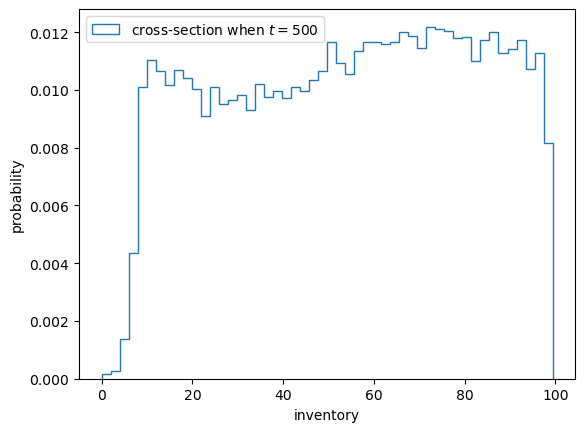

In [8]:
fig, ax = plt.subplots()
ax.hist(X_vec, bins=50, 
        density=True, 
        histtype='step', 
        label=f'cross-section when $t = {T}$')
ax.set_xlabel('inventory')
ax.set_ylabel('probability')
ax.legend()
plt.show()

## Distribution dynamics

Next let’s take a look at how the distribution sequence evolves over time.

We will go back to using ordinary Python `for` loops.

Here is code that repeatedly shifts the cross-section forward while
recording the cross-section at the dates in `sample_dates`.

In [9]:
def shift_forward_and_sample(x_init, params, sample_dates,
                             num_firms=50_000, sim_length=750):

    X = np.full((num_firms, ), x_init)
    X_samples = []
    # Use for loop to update X and collect samples
    for i in range(sim_length):
        if i in sample_dates:
            X_samples.append(X)
        Z = np.random.randn(num_firms)
        D = np.exp(params.μ + params.σ * Z)
        X = update_cross_section(params, X, D)

    return X_samples

Let’s test it

In [10]:
x_init = 50
num_firms = 10_000
sample_dates = 10, 50, 250, 500, 750

X_samples = shift_forward_and_sample(x_init, params, sample_dates)

Let’s plot the output.

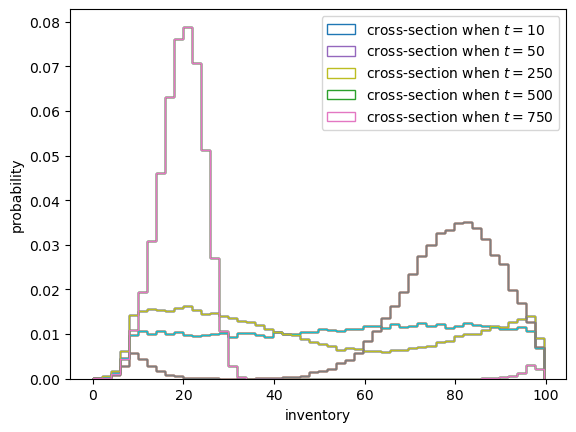

In [11]:
fig, ax = plt.subplots()

for i, date in enumerate(sample_dates):
    ax.hist(X_samples, bins=50, 
            density=True, 
            histtype='step',
            label=f'cross-section when $t = {date}$')

ax.set_xlabel('inventory')
ax.set_ylabel('probability')
ax.legend()
plt.show()

This model for inventory dynamics is asymptotically stationary, with a unique
stationary distribution.

In particular, the sequence of marginal distributions $ \{\psi_t\} $
converges to a unique limiting distribution that does not depend on
initial conditions.

Although we will not prove this here, we can see it in the simulation above.

By $ t=500 $ or $ t=750 $ the distributions are barely changing.

If you test a few different initial conditions, you will see that they do not affect long-run outcomes.

## Restock frequency

As an exercise, let’s study the probability that firms need to restock over a given time period.

In the exercise, we will

- set the starting stock level to $ X_0 = 70 $ and  
- calculate the proportion of firms that need to order twice or more in the first 50 periods.  


This proportion approximates the probability of the event when the sample size
is large.

In [12]:
def update_stock(n_restock, X, params, D):
    n_restock = np.where(X <= params.s,
                          n_restock + 1,
                          n_restock)
    X = np.where(X <= params.s,
                  np.maximum(params.S - D, 0),
                  np.maximum(X - D, 0))
    return n_restock, X

def compute_freq(params,
                 x_init=70,
                 sim_length=50,
                 num_firms=1_000_000):

    # Prepare initial arrays
    X = np.full((num_firms, ), x_init)

    # Stack the restock counter on top of the inventory
    n_restock = np.zeros((num_firms, ))

    # Use a for loop to perform the calculations on all states
    for i in range(sim_length):
        Z = np.random.randn(num_firms)
        D = np.exp(params.μ + params.σ * Z)
        n_restock, X = update_stock(
            n_restock, X, params, D)

    return np.mean(n_restock > 1, axis=0)

In [13]:
freq = compute_freq(params)
print(f"Frequency of at least two stock outs = {freq}")

Frequency of at least two stock outs = 0.44686
